# Mnist

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [2]:
# mnist 데이터 가져오기
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [3]:
# train 데이터의 shape 바꿔주기
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
                                
# 정규화
train_images, test_images = train_images/255.0, test_images/255.0

In [4]:
# train_test split
from sklearn.model_selection import train_test_split
valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.2, shuffle=True)

## sequential

In [5]:
# 모델 만들기
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1), padding='Same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='Same'))

# 순서대로 일렬로 만들기
model.add(layers.Flatten())

# 신경망 학습
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

2021-07-23 12:04:18.767584: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-07-23 12:04:18.778946: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd6e5b575d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-23 12:04:18.778958: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

## functional api

In [7]:
from tensorflow.keras.models import Model

# 모델 생성하기
inputs = layers.Input(shape=(28,28,1))
conv1 = layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu)(inputs)
pool1 = layers.MaxPooling2D(padding='same')(conv1)
conv2 = layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu)(pool1)
pool2 = layers.MaxPooling2D(padding='same')(conv2)
conv3 = layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu)(pool2)
pool3 = layers.MaxPooling2D(padding='same')(conv3)
pool3_flat = layers.Flatten()(pool3)
dense4 = layers.Dense(256, activation=tf.nn.relu)(pool3_flat)
drop4 = layers.Dropout(rate=0.2)(dense4)
logits = layers.Dense(units=10, activation='softmax')(drop4)
model = Model(inputs=inputs, outputs=logits)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 128)         0     

## 모델 클래스화 하기

In [9]:
# 배치 정규화
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

class ConvBNRelu(Model):
    def __init__(self, filters, kernel_size=3, strides=(1,1), padding="same"):
        super(ConvBNRelu, self).__init__()
        self.conv = layers.Conv2D(filters, kernel_size=kernel_size,
                                  strides=strides, padding=padding,
                                  kernel_initializer='glorot_normal')
        self.batchnorm = BatchNormalization()
        
    def call(self, inputs, training=False):
        layer = self.conv(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        
        return layer
    
class DenseBNRelu(Model):
    def __init__(self, units):
        super(DenseBNRelu, self).__init__()
        self.dense = layers.Dense(units=units, kernel_initializer='glorot_normal')
        self.batchnorm = BatchNormalization()
        
    def call(self, inputs, training=False):
        layer = self.dense(inputs)
        layer = self.batchnorm(layer)
        layer = tf.nn.relu(layer)
        
        return layer

In [10]:
class MNistModel(Model):
    def __init__(self):
        super(MNistModel, self).__init__()
        self.conv1 = ConvBNRelu(32, (3,3), padding='same')
        self.pool1 = layers.MaxPooling2D(padding='same')
        self.conv2 = ConvBNRelu(64, (3,3), padding='same')
        self.pool2 = layers.MaxPooling2D(padding='same')
        self.conv3 = ConvBNRelu(128, (3,3), padding='same')
        self.pool3 = layers.MaxPooling2D(padding='same')
        self.pool3_flat = layers.Flatten()
        self.dense4 = DenseBNRelu(256)
        self.drop4 = layers.Dropout(rate=0.2)
        self.dense5 = layers.Dense(units=10, activation='softmax', kernel_initializer='glorot_normal')
        
    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        output = self.dense5(net)
        
        return output

In [11]:
model = MNistModel()
model(layers.Input(shape=(28,28,1)))
model.summary()

Model: "m_nist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_bn_relu (ConvBNRelu)    (None, 28, 28, 32)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv_bn_relu_1 (ConvBNRelu)  (None, 14, 14, 64)        18752     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv_bn_relu_2 (ConvBNRelu)  (None, 7, 7, 128)         74368     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)             

## 학습 및 검증

In [12]:
# Earlystopping을 해보자!
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
MODEL_SAVE_FOLDER_PATH = '../../DATA'
model_file_path = f'{MODEL_SAVE_FOLDER_PATH}/mnist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5'

# 체크 포인트 지정
cb_checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_accuracy', verbose=1, save_best_only=True)

# 언제 멈출 것인가? patience(역전되었을 때도 얼마나 참아줄 것인지 정해주는 것)
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=6)

##### hdf5 저장문제
##### - tensorflow 버전 문제로 subclass 했던 것은 모델 저장 안 될 수 있음
##### - 저장을 위해 functional api로 돌리거나, tensorflow 2.2로 다운 그래이드할 것.

In [13]:
learning_rate = 0.001
batch_size = 100

# ExponentialDecay? 훈련 과정이 진행됨에 따라 lr을 조금씩(지수함수따라서 줄임) 낮춰가기 위한 방법
# (학습률, 스탭크기, 줄이는 비율)
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, train_images.shape[0]/batch_size*5, 0.5, staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)

# 모델 컴파일 하기
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# validation 추가 및 hist에 저장하여 그래프 그리는 재료로 사용하기
hist = model.fit(train_images, train_labels, 
                 validation_data = (valid_images, valid_labels), 
                 epochs=100,
                batch_size=200,
                callbacks=[cb_checkpoint, cb_early_stopping])

# 모델 테스트하여 loss 및 acc 저장하기
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9717
Epoch 00001: val_accuracy improved from -inf to 0.11587, saving model to ../../DATA/mnist-1-5.56499-0.11587.hdf5
300/300 [==============================] - 29s 96ms/step - loss: 0.0973 - accuracy: 0.9717 - val_loss: 5.5650 - val_accuracy: 0.1159
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9910
Epoch 00002: val_accuracy improved from 0.11587 to 0.97000, saving model to ../../DATA/mnist-2-0.09093-0.97000.hdf5
300/300 [==============================] - 30s 100ms/step - loss: 0.0302 - accuracy: 0.9910 - val_loss: 0.0909 - val_accuracy: 0.9700
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9934
Epoch 00003: val_accuracy improved from 0.97000 to 0.99075, saving model to ../../DATA/mnist-3-0.03048-0.99075.hdf5
300/300 [==============================] - 31s 103ms/step - loss: 0.0210 - accuracy: 0.9934 - val

모델 불러오기
model.load_weights(경로)

In [14]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

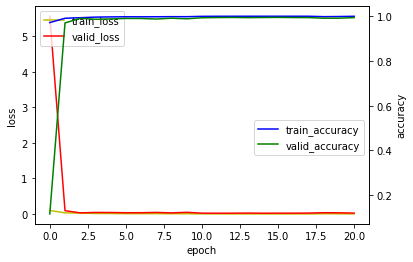

In [15]:
import matplotlib.pyplot as plt

def display(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='valid_loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train_accuracy')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='valid_accuracy')
    acc_ax.set_xlabel('epoch')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right', bbox_to_anchor=(1, 0.5))

    plt.show()

display(hist)

## pretrain된 자료 가져오기 (VGG16)

In [26]:
from tensorflow.keras.applications import VGG16
# mnist 데이터 가져오기
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

In [27]:
# VVG16에 맞춰 3차원으로 만들기
import numpy as np

# 3차원 만들기 위해 1차원 배열로 바꾼 후
train_images = train_images.reshape(-1, 784).astype('float32')
test_images = test_images.reshape(-1, 784).astype('float32')
# 3배로 증식해서
train_images = np.dstack([train_images]*3)
test_images = np.dstack([test_images]*3)
# 3차원으로 다시 형태 바꿔주기
train_images = train_images.reshape(-1, 28, 28, 3)
test_images = test_images.reshape(-1, 28, 28, 3)

In [28]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
# 이미지 확대하기
train_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in train_images])
test_images = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48, 48))) for im in test_images])  

train_images.shape, test_images.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [29]:
# 정규화
train_images = train_images/255.
test_images = test_images/255.

valid_images, test_images, valid_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.2, shuffle=True)

In [30]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [33]:
layer_dict = {layer.name : layer for layer in vgg_model.layers}
x = layer_dict['block2_pool'].output

x = ConvBNRelu(filters=64, kernel_size=(3, 3))(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = DenseBNRelu(256)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation='softmax')(x)

In [35]:
custom_model = Model(inputs=vgg_model.input, outputs=x)
custom_model

In [37]:
# 커스텀 모델 프리징 (학습 안함)
for layer in custom_model.layers[:7]:
    layer.trainable = False

learning_rate = 0.001
batch_size = 100

# ExponentialDecay? 훈련 과정이 진행됨에 따라 lr을 조금씩(지수함수따라서 줄임) 낮춰가기 위한 방법
# (학습률, 스탭크기, 줄이는 비율)
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, train_images.shape[0]/batch_size*5, 0.5, staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)

# 모델 컴파일 하기
custom_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# validation 추가 및 hist에 저장하여 그래프 그리는 재료로 사용하기
hist = custom_model.fit(train_images, train_labels, 
                 validation_data = (valid_images, valid_labels), 
                 epochs=100,
                batch_size=200,
                callbacks=[cb_checkpoint, cb_early_stopping])

#### 시간 오래걸린다!

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.0760 - accuracy: 0.9777
Epoch 00001: val_accuracy did not improve from 0.99488
300/300 [==============================] - 107s 357ms/step - loss: 0.0760 - accuracy: 0.9777 - val_loss: 0.0365 - val_accuracy: 0.9879
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9928
Epoch 00002: val_accuracy did not improve from 0.99488
300/300 [==============================] - 108s 361ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0225 - val_accuracy: 0.9929
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9953
Epoch 00003: val_accuracy did not improve from 0.99488
300/300 [==============================] - 106s 353ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.0231 - val_accuracy: 0.9925
Epoch 4/100
300/300 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9965
Epoch 00004: val_accuracy did not improve 

KeyboardInterrupt: 

In [ ]:
custom_model.load_weights()
test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)